In [112]:

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [113]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [114]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func



In [115]:
# create engine to Hawaii.sqlite
engine= create_engine(f"sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [116]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [117]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [118]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [119]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [120]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"{most_recent_date}")


2017-08-23


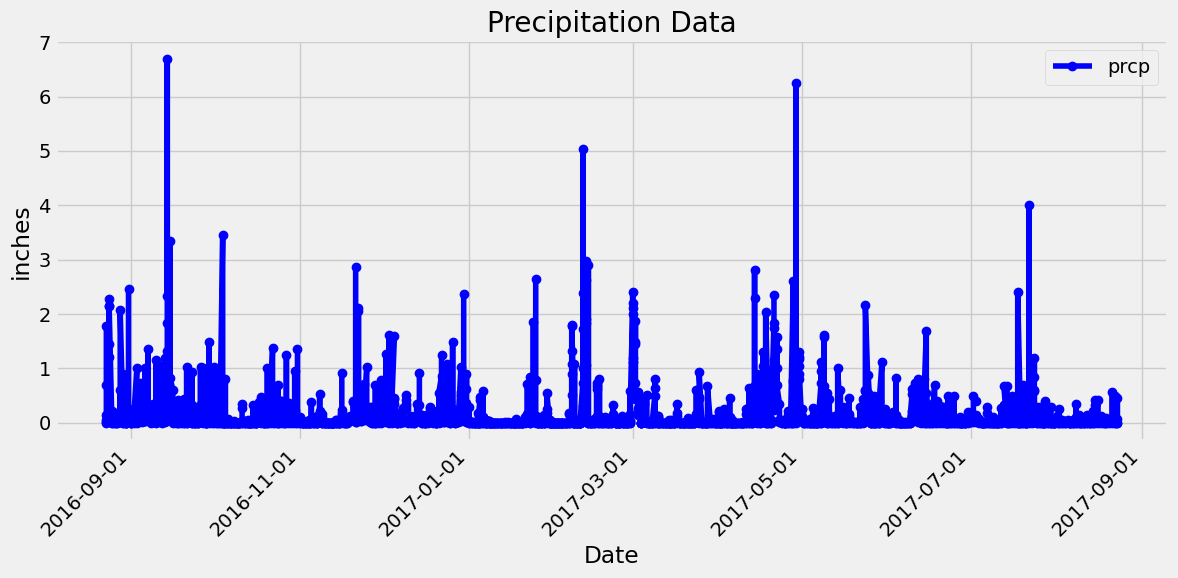

In [121]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
style.use('fivethirtyeight')
# Calculate the date one year from the last date in data set.

start_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(
    Measurement.date >= func.date(most_recent_date, '-12 months')
).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(query, columns=['date', 'prcp'])
df['date'] = pd.to_datetime(df['date'])


# Sort the dataframe by date
df = df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(12, 6))
df.plot(x='date', y='prcp', kind='line', linestyle='-', color='b', marker='o', ax=plt.gca())
plt.title('Precipitation Data')
plt.xlabel('Date')
plt.ylabel('inches')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [122]:
# Use Pandas to calculate the summary statistics for the precipitation data
print("Summary Statistics for Precipitation Data:")
print(df['prcp'].describe())

Summary Statistics for Precipitation Data:
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [123]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"{total_stations}")

9


In [124]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations_query = session.query(
    Measurement.station,
    func.count(Measurement.station).label('count')
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

for station, count in active_stations_query:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [125]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations_query[0][0]

temperature_data = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station).all()

# Print the temperature statistics
for min_temp, max_temp, avg_temp in temperature_data:
    print(f"Lowest Temperature: {min_temp}F")
    print(f"Highest Temperature: {max_temp}F")
    print(f"Average Temperature: {avg_temp}F")

Lowest Temperature: 54.0F
Highest Temperature: 85.0F
Average Temperature: 71.66378066378067F


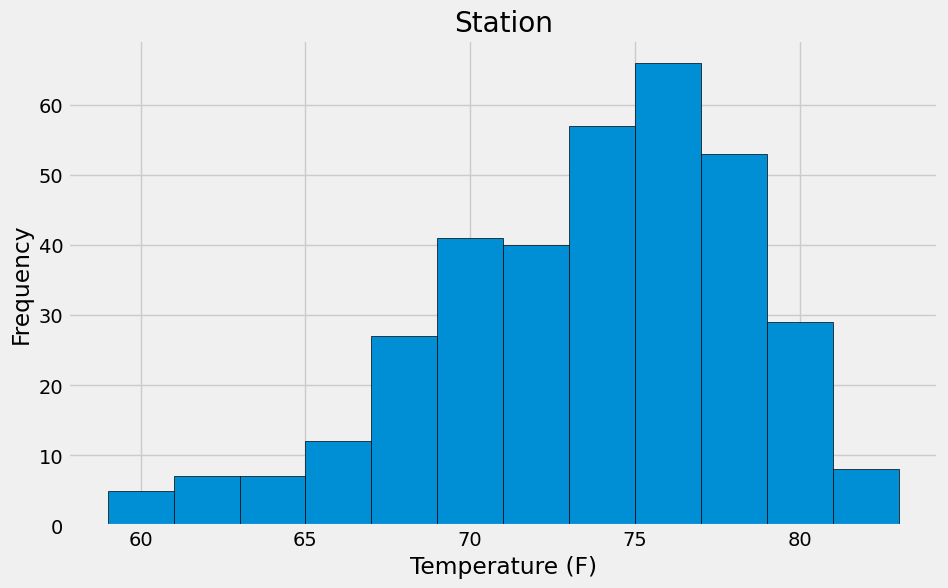

In [126]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_query = session.query(Measurement.tobs).filter(
    Measurement.station == most_active_station,
    Measurement.date >= start_date.strftime('%Y-%m-%d')
).all()

# Convert the query results to a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_query, columns=['tobs'])

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_df['tobs'], bins=12, edgecolor='black')
plt.title('Station')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Close Session

In [127]:
# Close Session
session.close()